# <u>Geometric image classification substructure of the Hornsund Fjord: Time Series Analysis </u>  <br /> <sub> <span style="font-size:smaller;"> Jullian C.B. Williams </span> </sub> <br /> <sub> <span style="font-size:smaller;"> *Polish Academy of Sciences, Institute of Geophysics, Warsaw, Poland* </span> </sub>


In [1]:
import emoji #<---- Death and taxes are for certain. Try to have fun before you're 6 feet too far under to.
from rich.console import Console #<---- Ditto.

import fiona
import random
import warnings
import argparse, os
import pyarrow as pa
from datetime import datetime
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.affinity import translate

import numpy as np
import pandas as pd
from osgeo import ogr
from osgeo import gdal #<---- to geospatial env.
import geopandas as gpd

from PIL import Image


import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import show_hist 
from rasterstats import zonal_stats
from rasterio.features import shapes
from rasterio.plot import adjust_band
from rasterio.features import rasterize

import seaborn as sns
import matplotlib.image
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from spectral import *
from sklearn import svm
from scipy import stats
from scipy import ndimage
from sklearn.svm import SVC
from scipy.ndimage import zoom
from scipy.ndimage import sobel
from scipy.stats import entropy
import spectral.io.envi as envi #run PCA
from sklearn.svm import LinearSVC
from skimage import io, transform # from scipy.misc import imresize  <---- here...we...go..
from skimage.morphology import disk #manage disk while running.
from skimage.segmentation import slic
from skimage.util import img_as_ubyte #Avoid precision loss converting image of type float32 to uint8 as required by rank filters.
from skimage.filters.rank import entropy #for GLCM entropy.
from sklearn.pipeline import make_pipeline
from skimage.segmentation import chan_vese
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops # from skimage.feature import greycomatrix, greycoprops <--- depreciated or..? lang.
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

# SVM

## Winter

In [7]:
input_dir = "C:/Users/jullian.williams/Desktop/Winter/"

dataframes = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)

                        name, ext = os.path.splitext(filename)
                        raftposition = 17
                        bfposition = 9
                
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                        fname = f"{file_name[bfposition:]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':fname}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            dataframes.append(gdf)

In [16]:
winter = dataframes

In [17]:
rswinter = pd.concat(winter, ignore_index=True)
print(rswinter)

         value                                           geometry       date  \
0          0.0  POLYGON ((500275 8558875, 500275 8558825, 5003... 2012-02-03   
1          1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-02-03   
2          1.0  POLYGON ((501175 8558075, 501175 8558025, 5010... 2012-02-03   
3          0.0  POLYGON ((499575 8557625, 499575 8557575, 4996... 2012-02-03   
4          0.0  POLYGON ((500575 8557575, 500575 8557525, 5006... 2012-02-03   
...        ...                                                ...        ...   
1185864    1.0  POLYGON ((499425 8549075, 499425 8549025, 4993... 2016-03-01   
1185865    0.0  POLYGON ((510575 8531025, 510575 8530975, 5107... 2016-03-01   
1185866    0.0  POLYGON ((498975 8559025, 498975 8558275, 4990... 2016-03-01   
1185867    0.0  POLYGON ((511875 8531025, 511875 8530975, 5119... 2016-03-01   
1185868    1.0  POLYGON ((512925 8531075, 512925 8531025, 5128... 2016-03-01   

                area  perimeter        

In [18]:
rsw = rswinter.drop(rswinter[rswinter['area'] >= 2e7].index) # Remove wrapper cells
print(rsw)

         value                                           geometry       date  \
0          0.0  POLYGON ((500275 8558875, 500275 8558825, 5003... 2012-02-03   
1          1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-02-03   
2          1.0  POLYGON ((501175 8558075, 501175 8558025, 5010... 2012-02-03   
3          0.0  POLYGON ((499575 8557625, 499575 8557575, 4996... 2012-02-03   
4          0.0  POLYGON ((500575 8557575, 500575 8557525, 5006... 2012-02-03   
...        ...                                                ...        ...   
1185862    0.0  POLYGON ((507675 8531025, 507675 8530975, 5077... 2016-03-01   
1185863    0.0  POLYGON ((507825 8531025, 507825 8530975, 5079... 2016-03-01   
1185865    0.0  POLYGON ((510575 8531025, 510575 8530975, 5107... 2016-03-01   
1185867    0.0  POLYGON ((511875 8531025, 511875 8530975, 5119... 2016-03-01   
1185868    1.0  POLYGON ((512925 8531075, 512925 8531025, 5128... 2016-03-01   

            area  perimeter            

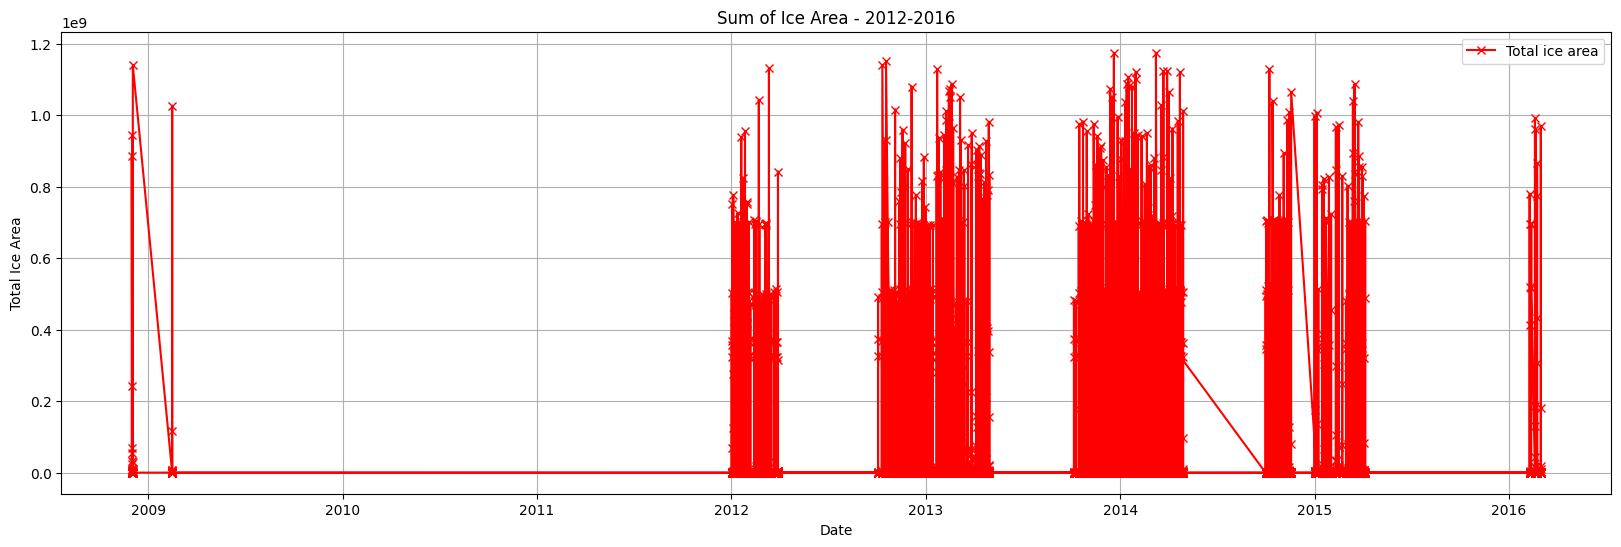

In [19]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(rswinter['date'], rswinter['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012-2016')
plt.legend()
plt.grid()
plt.show()

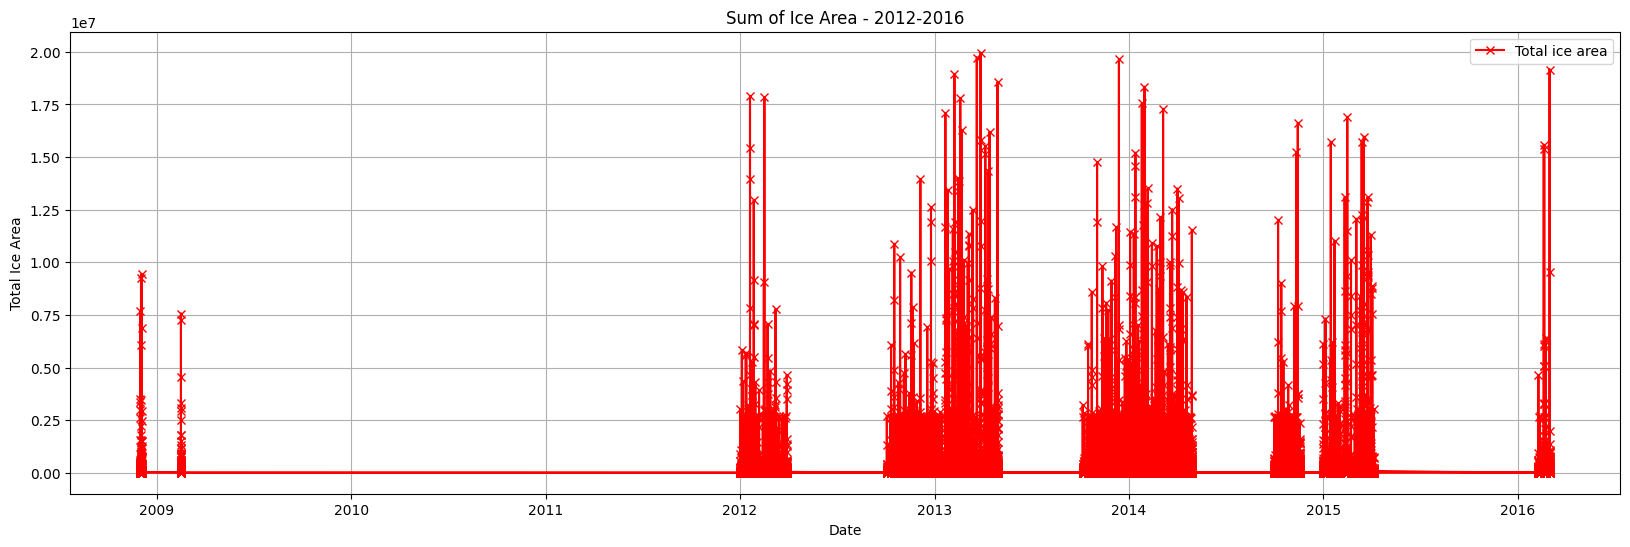

In [20]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(rsw['date'], rsw['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012-2016')
plt.legend()
plt.grid()
plt.show()

In [27]:
result = rsw.groupby(['date', 'value'])['area'].sum().reset_index()
print(result)

          date  value        area
0   2008-12-01    0.0   9810000.0
1   2008-12-01    1.0  49617500.0
2   2008-12-02    0.0   8672500.0
3   2008-12-02    1.0  99442500.0
4   2008-12-03    0.0   2202500.0
..         ...    ...         ...
747 2016-02-22    1.0  12925000.0
748 2016-02-23    0.0  21592500.0
749 2016-02-23    1.0  35187500.0
750 2016-03-01    0.0   8227500.0
751 2016-03-01    1.0  71212500.0

[752 rows x 3 columns]


In [28]:
ice_area = result[result['value'] == 1] 
print(ice_area)

          date  value        area
1   2008-12-01    1.0  49617500.0
3   2008-12-02    1.0  99442500.0
5   2008-12-03    1.0  40552500.0
7   2009-02-15    1.0  62160000.0
9   2012-01-02    1.0   1140000.0
..         ...    ...         ...
743 2016-02-19    1.0  52227500.0
745 2016-02-20    1.0  65177500.0
747 2016-02-22    1.0  12925000.0
749 2016-02-23    1.0  35187500.0
751 2016-03-01    1.0  71212500.0

[376 rows x 3 columns]


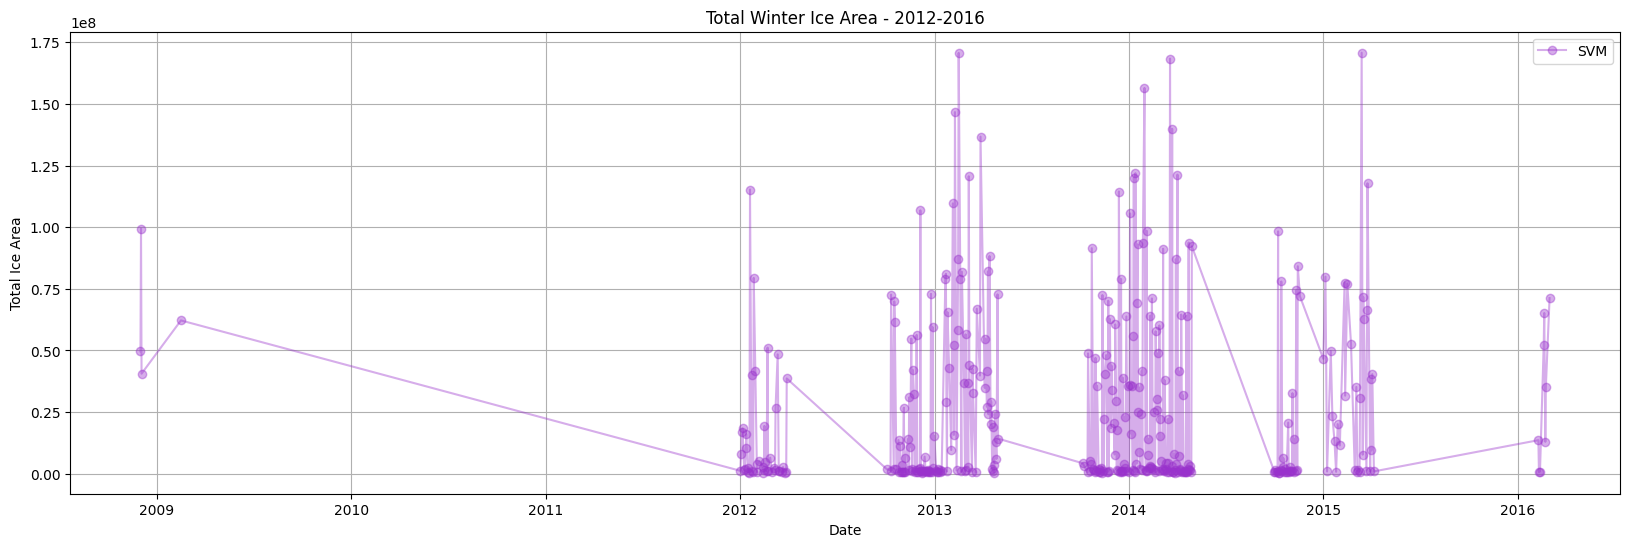

In [29]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(ice_area['date'], ice_area['area'], c='darkorchid', marker='o', alpha=0.4, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Total Winter Ice Area - 2012-2016')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

## Summer

In [21]:
input_dir = "C:/Users/jullian.williams/Desktop/Summer/"

dataframes_ = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)

                        name, ext = os.path.splitext(filename)
                        raftposition = 17
                        bfposition = 9
                
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                        fname = f"{file_name[bfposition:]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':fname}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            dataframes_.append(gdf)

In [22]:
summer = dataframes_

In [23]:
rssummer = pd.concat(summer, ignore_index=True)
print(rssummer)

        value                                           geometry       date  \
0         1.0  POLYGON ((498975 8559025, 498975 8558875, 4990... 2012-05-06   
1         1.0  POLYGON ((499475 8559025, 499475 8558975, 4993... 2012-05-06   
2         1.0  POLYGON ((499675 8558775, 499675 8558725, 4997... 2012-05-06   
3         1.0  POLYGON ((499175 8558675, 499175 8558625, 4992... 2012-05-06   
4         1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-05-06   
...       ...                                                ...        ...   
635213    1.0  POLYGON ((505225 8531225, 505225 8531175, 5053... 2014-09-30   
635214    1.0  POLYGON ((506375 8531425, 506375 8531325, 5064... 2014-09-30   
635215    0.0  POLYGON ((498975 8559025, 498975 8558125, 4990... 2014-09-30   
635216    1.0  POLYGON ((510675 8531225, 510675 8531175, 5107... 2014-09-30   
635217    1.0  POLYGON ((512675 8531225, 512675 8531175, 5127... 2014-09-30   

                area  perimeter                    

In [24]:
rss = rssummer.drop(rssummer[rssummer['area'] >= 2e7].index) # Remove wrapper cells
print(rss)

        value                                           geometry       date  \
0         1.0  POLYGON ((498975 8559025, 498975 8558875, 4990... 2012-05-06   
1         1.0  POLYGON ((499475 8559025, 499475 8558975, 4993... 2012-05-06   
2         1.0  POLYGON ((499675 8558775, 499675 8558725, 4997... 2012-05-06   
3         1.0  POLYGON ((499175 8558675, 499175 8558625, 4992... 2012-05-06   
4         1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-05-06   
...       ...                                                ...        ...   
635212    1.0  POLYGON ((503475 8531225, 503475 8531175, 5036... 2014-09-30   
635213    1.0  POLYGON ((505225 8531225, 505225 8531175, 5053... 2014-09-30   
635214    1.0  POLYGON ((506375 8531425, 506375 8531325, 5064... 2014-09-30   
635216    1.0  POLYGON ((510675 8531225, 510675 8531175, 5107... 2014-09-30   
635217    1.0  POLYGON ((512675 8531225, 512675 8531175, 5127... 2014-09-30   

            area  perimeter                        

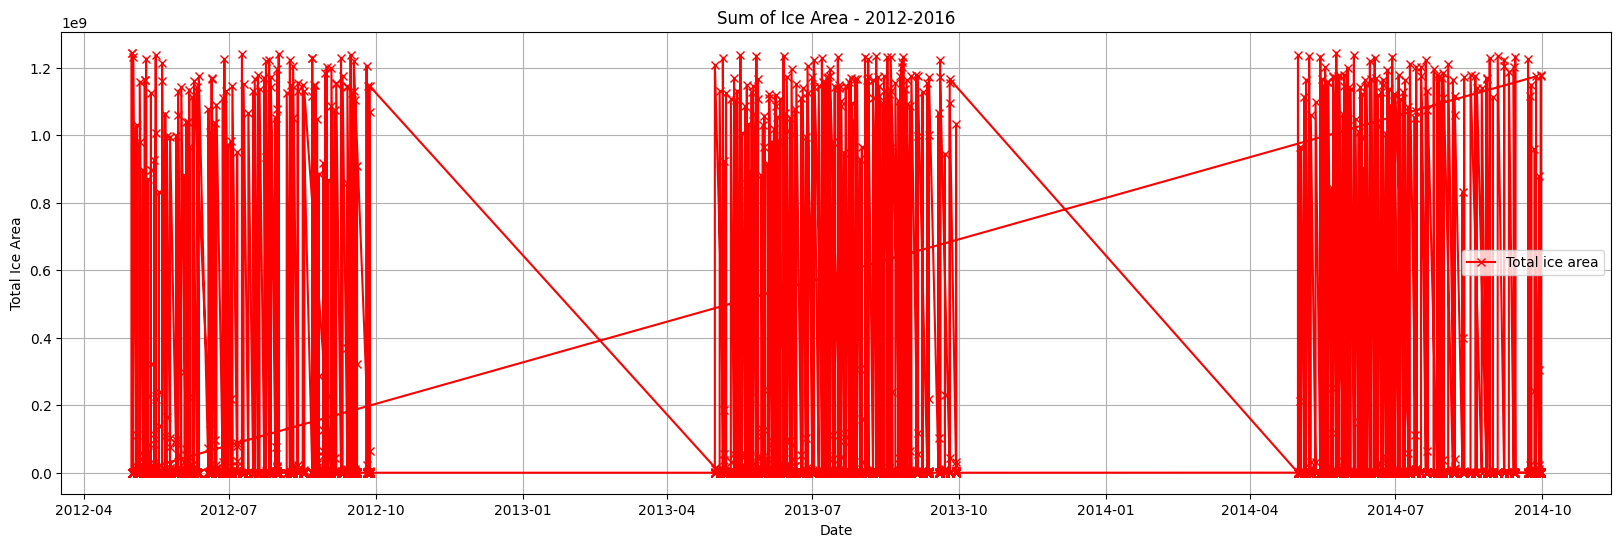

In [25]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(rssummer['date'], rssummer['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012-2016')
plt.legend()
plt.grid()
plt.show()

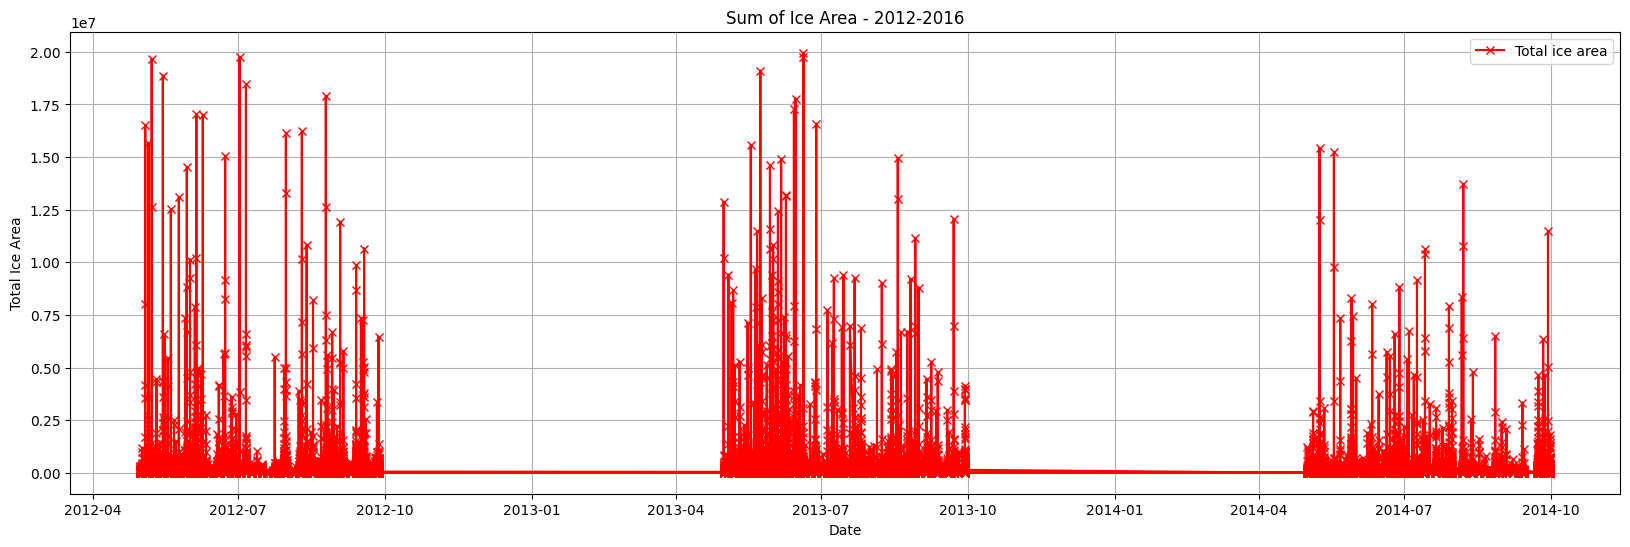

In [26]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(rss['date'], rss['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012-2016')
plt.legend()
plt.grid()
plt.show()

In [30]:
result_ = rss.groupby(['date', 'value'])['area'].sum().reset_index()
print(result_)

          date  value        area
0   2012-05-01    0.0  41185000.0
1   2012-05-02    0.0  32780000.0
2   2012-05-04    0.0  13797500.0
3   2012-05-04    1.0  54702500.0
4   2012-05-06    0.0  20147500.0
..         ...    ...         ...
495 2014-09-27    1.0  18025000.0
496 2014-09-29    0.0  21695000.0
497 2014-09-29    1.0  37110000.0
498 2014-09-30    0.0   1500000.0
499 2014-09-30    1.0  89635000.0

[500 rows x 3 columns]


In [31]:
ice_area_ = result_[result_['value'] == 1] 
print(ice_area_)

          date  value         area
3   2012-05-04    1.0   54702500.0
5   2012-05-06    1.0  111597500.0
7   2012-05-08    1.0   52832500.0
9   2012-05-09    1.0    2540000.0
12  2012-05-11    1.0   45520000.0
..         ...    ...          ...
491 2014-09-24    1.0   76642500.0
493 2014-09-26    1.0   47352500.0
495 2014-09-27    1.0   18025000.0
497 2014-09-29    1.0   37110000.0
499 2014-09-30    1.0   89635000.0

[243 rows x 3 columns]


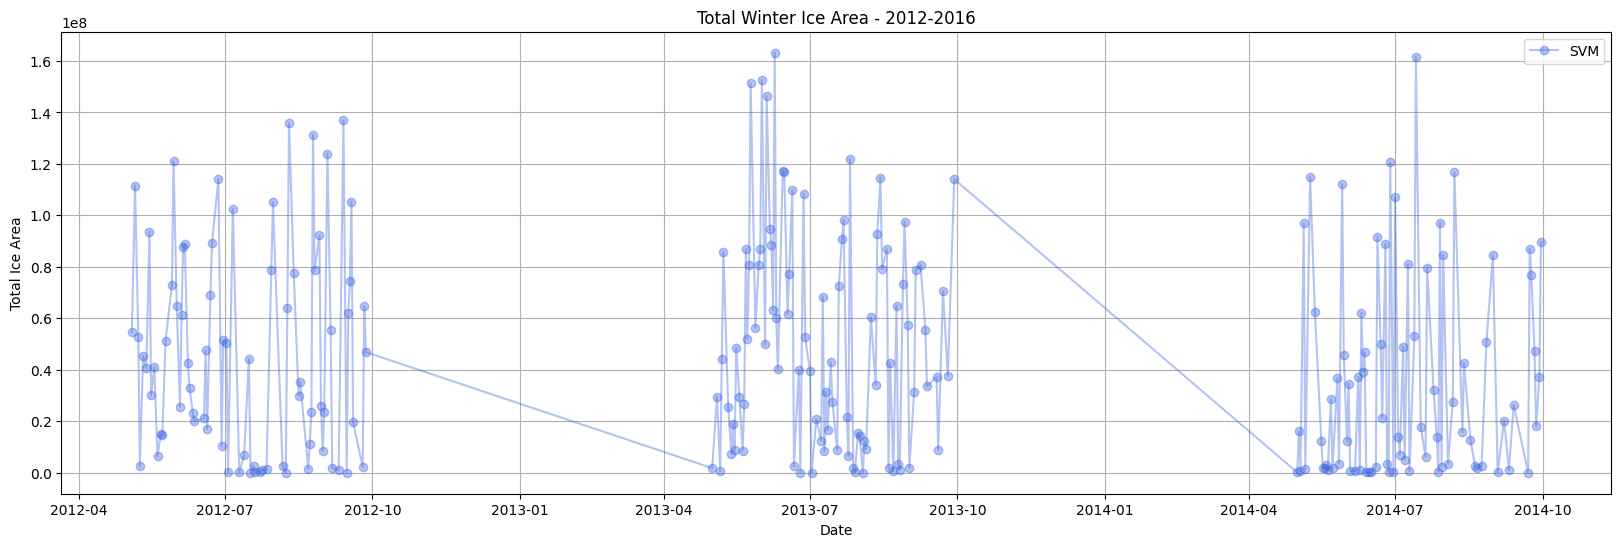

In [32]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(ice_area_['date'], ice_area_['area'], c='royalblue', marker='o', alpha=0.4, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Total Winter Ice Area - 2012-2016')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

# All seasons

In [20]:
input_dir = "C:/Users/jullian.williams/Desktop/RS_12_16/"

df = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)

                        name, ext = os.path.splitext(filename)
                        raftposition = 17
                        bfposition = 9
                
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                        fname = f"{file_name[bfposition:]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':fname}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            df.append(gdf)

In [ ]:
rs2 = pd.concat(df, ignore_index=True)
print(rs2)

In [ ]:
rs2 = rs2.drop(rs2[rs2['area'] >= 2e7].index) # Remove wrapper cells
print(rs2)

In [24]:
rt = rs2.groupby(['date', 'value'])['area'].sum().reset_index()
print(rt)

           date  value        area
0    2012-01-02    0.0  14067500.0
1    2012-01-02    1.0   1140000.0
2    2012-01-03    0.0  24877500.0
3    2012-01-03    1.0   7987500.0
4    2012-01-05    0.0  17307500.0
...         ...    ...         ...
1239 2016-02-22    1.0  12925000.0
1240 2016-02-23    0.0  21592500.0
1241 2016-02-23    1.0  35187500.0
1242 2016-03-01    0.0   8227500.0
1243 2016-03-01    1.0  71212500.0

[1244 rows x 3 columns]


In [25]:
iceara = rt[rt['value'] == 1] 
print(iceara)

           date  value        area
1    2012-01-02    1.0   1140000.0
3    2012-01-03    1.0   7987500.0
5    2012-01-05    1.0  16722500.0
7    2012-01-06    1.0  18317500.0
9    2012-01-09    1.0   1452500.0
...         ...    ...         ...
1235 2016-02-19    1.0  52227500.0
1237 2016-02-20    1.0  65177500.0
1239 2016-02-22    1.0  12925000.0
1241 2016-02-23    1.0  35187500.0
1243 2016-03-01    1.0  71212500.0

[615 rows x 3 columns]


In [23]:
r = rs2.groupby(['date'])['area'].sum().reset_index()
print(r)

          date        area
0   2012-01-02  15207500.0
1   2012-01-03  32865000.0
2   2012-01-05  34030000.0
3   2012-01-06  27402500.0
4   2012-01-09  17010000.0
..         ...         ...
634 2016-02-19  61880000.0
635 2016-02-20  82295000.0
636 2016-02-22  20935000.0
637 2016-02-23  56780000.0
638 2016-03-01  79440000.0

[639 rows x 2 columns]


In [106]:
xm = pd.merge(iceara,r, on='date',how='outer').fillna(0)
xm['perc'] = (xm['area_x']/xm['area_y'])*100
xm['julian'] = xm['date'].dt.strftime('%j')
print(xm)

          date  value      area_x      area_y       perc julian
0   2012-01-02    1.0   1140000.0  15207500.0   7.496301    002
1   2012-01-03    1.0   7987500.0  32865000.0  24.303971    003
2   2012-01-05    1.0  16722500.0  34030000.0  49.140464    005
3   2012-01-06    1.0  18317500.0  27402500.0  66.846091    006
4   2012-01-09    1.0   1452500.0  17010000.0   8.539095    009
..         ...    ...         ...         ...        ...    ...
634 2016-02-19    1.0  52227500.0  61880000.0  84.401261    050
635 2016-02-20    1.0  65177500.0  82295000.0  79.199830    051
636 2016-02-22    1.0  12925000.0  20935000.0  61.738715    053
637 2016-02-23    1.0  35187500.0  56780000.0  61.971645    054
638 2016-03-01    1.0  71212500.0  79440000.0  89.643127    061

[639 rows x 6 columns]


C:\Users\jullian.williams\AppData\Local\Temp\ipykernel_10512\3509871196.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


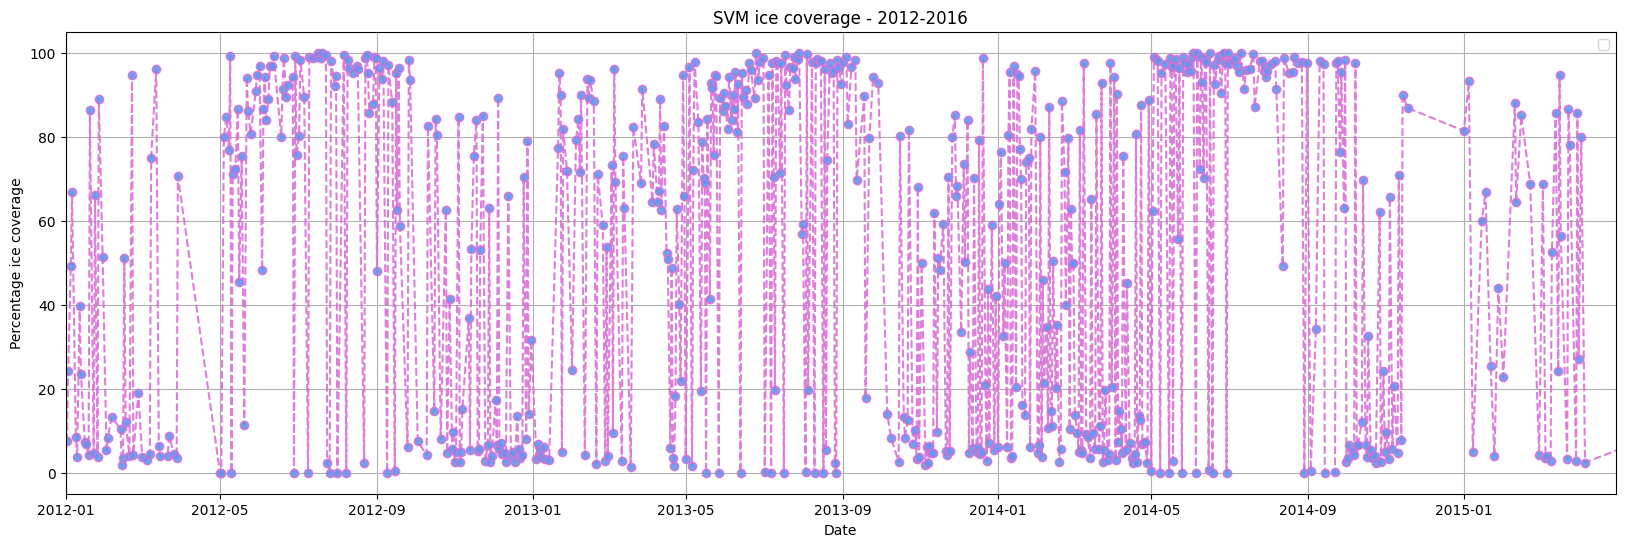

In [94]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(xm['date'], xm['perc'], c='orchid', linestyle='--', marker='o',markerfacecolor='cornflowerblue', alpha=0.9)
plt.xlabel('Date')
plt.ylabel('Percentage ice coverage')
start_date = datetime(2012, 1, 1)
end_date = datetime(2015, 4, 30)
plt.xlim(start_date, end_date)
# plt.ylim(0,1.3e6)
plt.title('SVM ice coverage - 2012-2016')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

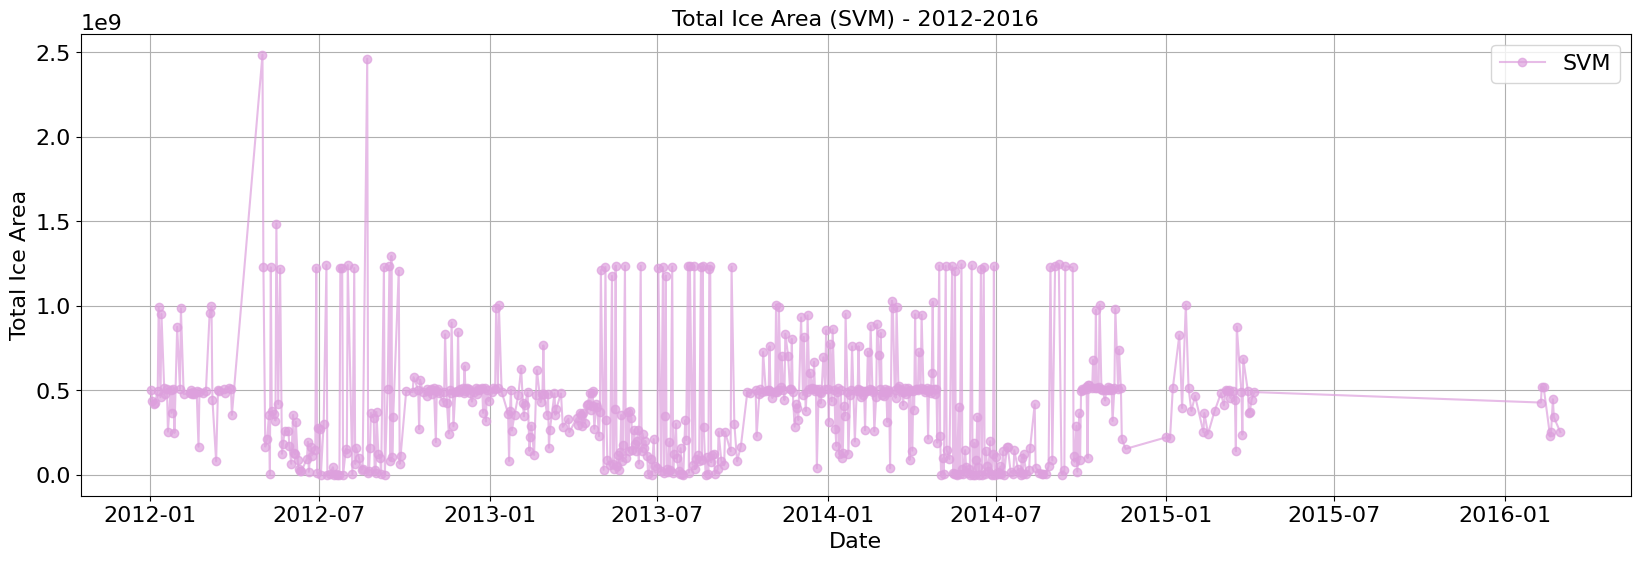

In [125]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(iceara['date'], iceara['area'], c='plum', marker='o', alpha=0.7, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Total Ice Area (SVM) - 2012-2016')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

## Linear regression

In [113]:
print(xm['perc'].dtype)

float64


In [81]:
y = xm['area_y'].to_numpy()
stlist = xm['julian'].to_numpy()
x = [float(i) for i in stlist]
x = np.array(x)
print(x)

[  2.   3.   5.   6.   9.  10.  12.  13.  16.  17.  19.  20.  23.  24.
  26.  27.  30.  33.  34.  37.  44.  45.  46.  47.  48.  51.  53.  54.
  58.  61.  65.  67.  68.  72.  74.  75.  81.  82.  86.  88.  89. 125.
 127. 129. 130. 132. 134. 136. 137. 139. 141. 143. 144. 146. 150. 151.
 153. 155. 156. 157. 158. 160. 161. 163. 164. 170. 171. 172. 174. 175.
 179. 181. 182. 184. 185. 188. 192. 195. 198. 199. 201. 202. 205. 206.
 209. 212. 213. 219. 221. 222. 223. 226. 229. 230. 235. 236. 237. 238.
 239. 242. 243. 244. 245. 247. 249. 250. 254. 257. 259. 260. 261. 262.
 263. 269. 270. 271. 277. 284. 285. 290. 291. 292. 295. 299. 300. 302.
 304. 305. 306. 307. 309. 310. 311. 312. 317. 318. 319. 321. 323. 324.
 325. 326. 328. 330. 332. 333. 334. 335. 338. 339. 340. 341. 342. 343.
 345. 346. 348. 350. 352. 353. 355. 356. 357. 359. 360. 362. 363. 364.
 366.   4.   5.   7.   8.  10.  11.  14.  21.  22.  23.  24.  25.  28.
  32.  35.  37.  38.  39.  42.  44.  45.  46.  49.  51.  52.  56.  58.
  59. 

In [82]:
def calc_linreg_coef(x,y):
    if(np.size(x) !=np.size(y)):
        sys.exit("Length of x and y are not the same")

    #Number of observations
    n = np.size(x)

    sx = np.sum(x)
    sy = np.sum(y)
    
    sx2 = np.inner(x,x)
    sxy = np.inner(x,y)
    sy2 = np.inner(y,y)

    #Calculation of regression coefficients
    a1 = (n*sxy - sx*sy)/(n*sx2 - sx**2)
    a0 = (sy/n) - (a1*sx)/n

    r2 = ((n*sxy-sx*sy)/np.sqrt(n*sx2-sx**2)/np.sqrt(n*sy2-sy**2))**2;
          
    return (a0, a1, r2)
        

In [83]:
a0, a1, r2 = calc_linreg_coef(x,y)

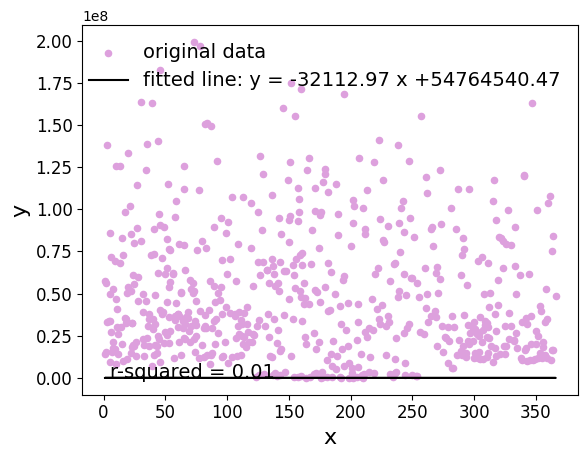

In [86]:
plt.scatter(x,y, c= 'plum', marker='o', s=20, label = 'original data')
y_pred = a0 + a1*x
plt.plot(x,predictions, color = 'k', label = 'fitted line: y = %.2f x +%.2f'%(a1,a0)) 
plt.text(5,5,'r-squared = %.2f'%r2, fontsize = 14) 
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize =16)
plt.tick_params(axis='both', which='major', labelsize = 12)
plt.legend(loc='upper right', fontsize = 14, frameon=False)
plt.show()

## Gaussian 

In [87]:
input_dir = "C:/Users/jullian.williams/Desktop/z_16/"

df_ = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)
                        
                        name, ext = os.path.splitext(filename)
                        raftposition = 8
                    
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':file_name}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            df_.append(gdf)

In [88]:
rs2bin = pd.concat(df_, ignore_index=True)
print(rs2bin)

        value                                           geometry       date  \
0         1.0  POLYGON ((499625 8557925, 499625 8557875, 4995... 2012-01-02   
1         1.0  POLYGON ((522875 8557375, 522875 8557325, 5228... 2012-01-02   
2         1.0  POLYGON ((498975 8556975, 498975 8556825, 4990... 2012-01-02   
3         1.0  POLYGON ((523075 8556725, 523075 8556675, 5231... 2012-01-02   
4         1.0  POLYGON ((523175 8556675, 523175 8556625, 5232... 2012-01-02   
...       ...                                                ...        ...   
146202    1.0  POLYGON ((509525 8533525, 509525 8533475, 5094... 2016-03-03   
146203    0.0  POLYGON ((508975 8531125, 508975 8531075, 5089... 2016-03-03   
146204    0.0  POLYGON ((498975 8559025, 498975 8552125, 4990... 2016-03-03   
146205    1.0  POLYGON ((513525 8531075, 513525 8530975, 5135... 2016-03-03   
146206    1.0  POLYGON ((501975 8531125, 501975 8531075, 5019... 2016-03-03   

                area  perimeter                    

In [116]:
rst = rs2bin.groupby(['date', 'value'])['area'].sum().reset_index()
print(rst)

           date  value          area
0    2012-01-02    0.0  1.260702e+09
1    2012-01-02    1.0  2.950000e+06
2    2012-01-03    0.0  1.196255e+09
3    2012-01-03    1.0  6.739750e+07
4    2012-01-05    0.0  1.237650e+09
...         ...    ...           ...
1564 2016-02-29    1.0  5.633750e+07
1565 2016-03-01    0.0  1.224568e+09
1566 2016-03-01    1.0  3.908500e+07
1567 2016-03-03    0.0  1.239822e+09
1568 2016-03-03    1.0  2.383000e+07

[1569 rows x 3 columns]


In [117]:
iara = rst[rst['value'] == 1] 
print(iara)

           date  value        area
1    2012-01-02    1.0   2950000.0
3    2012-01-03    1.0  67397500.0
5    2012-01-05    1.0  26002500.0
7    2012-01-06    1.0  16237500.0
9    2012-01-09    1.0  66387500.0
...         ...    ...         ...
1560 2016-02-23    1.0  44572500.0
1562 2016-02-27    1.0  89947500.0
1564 2016-02-29    1.0  56337500.0
1566 2016-03-01    1.0  39085000.0
1568 2016-03-03    1.0  23830000.0

[744 rows x 3 columns]


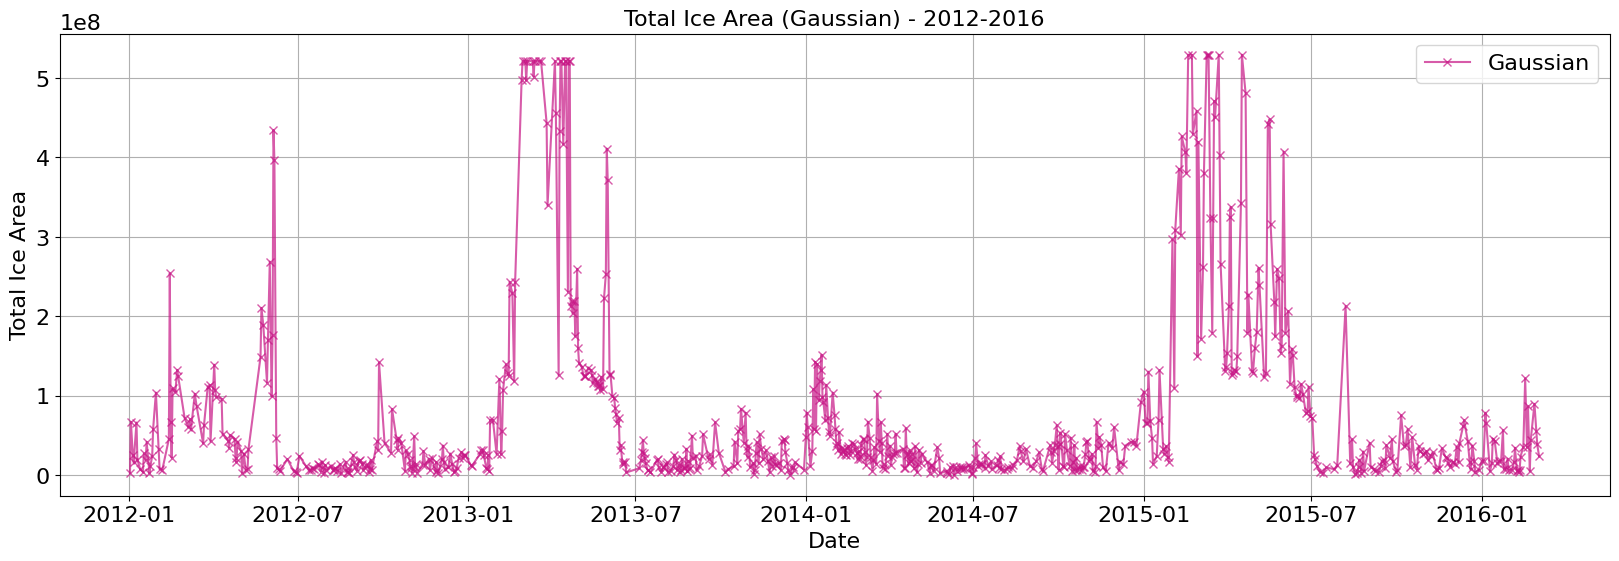

In [118]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(iara['date'], iara['area'], c='mediumvioletred', marker='x', alpha=0.7, label='Gaussian')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Total Ice Area (Gaussian) - 2012-2016')
plt.legend()
plt.grid()
plt.show()

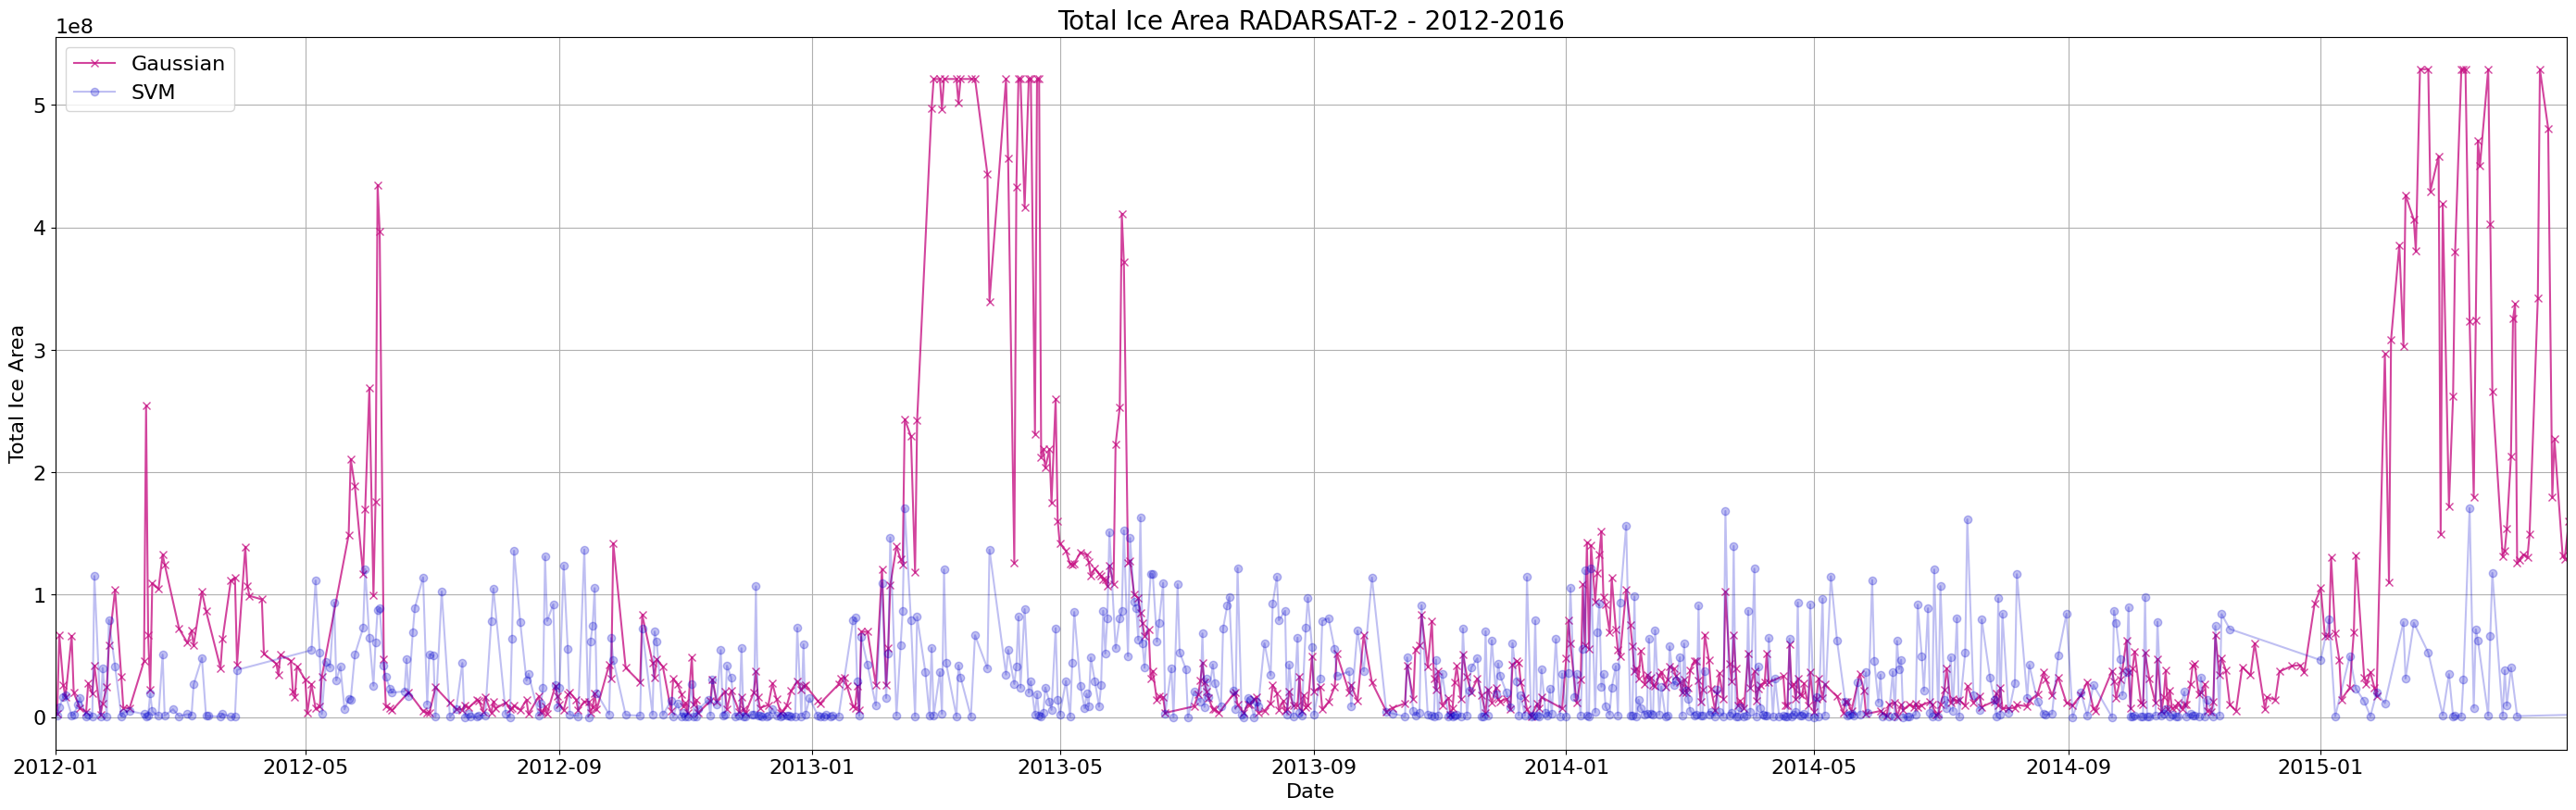

In [130]:
# Plot the results
plt.figure(figsize=(35, 10))
plt.rcParams.update({'font.size': 16})
plt.plot(iara['date'], iara['area'], c='mediumvioletred', marker='x', alpha=0.8, label='Gaussian')
plt.plot(iceara['date'], iceara['area'], c='mediumblue', marker='o', alpha=0.25, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
start_date = datetime(2012, 1, 1)
end_date = datetime(2015, 4, 30)
plt.xlim(start_date, end_date)
# plt.ylim(0,1.8e8)
plt.title('Total Ice Area RADARSAT-2 - 2012-2016', fontsize=20)
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

In [90]:
i = rs2bin.groupby(['date'])['area'].sum().reset_index()
print(i)

          date          area
0   2012-01-02  1.263652e+09
1   2012-01-03  1.263652e+09
2   2012-01-05  1.263652e+09
3   2012-01-06  1.263652e+09
4   2012-01-09  1.263652e+09
..         ...           ...
820 2016-02-23  1.263652e+09
821 2016-02-27  1.263652e+09
822 2016-02-29  1.263652e+09
823 2016-03-01  1.263652e+09
824 2016-03-03  1.263652e+09

[825 rows x 2 columns]


In [ ]:
x = i[q['value'] == 1] 
print(x)